In [1]:
import pandas as pd
import h5py
import numpy as np
import pandas as pd
import geopy
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import os, tqdm
import matplotlib.pyplot as plt
import reverse_geocode
import pycountry_convert as pc
import xgboost as xgb
import tensorflow as tf

from matplotlib.dates import date2num
from datetime import datetime
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from geopandas import GeoDataFrame
from shapely.geometry import Point
from sklearn.model_selection import KFold
from tensorflow.keras import models, layers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.callbacks import EarlyStopping
from IPython.display import Markdown
from pprint import pprint
from typing import Tuple
from tqdm import tqdm
tqdm.pandas()
geolocator = Photon(user_agent="jupyter_lab")

In [2]:
df_indonesia = pd.read_csv("GEMPA INDONESIA FIX.csv", sep =',')
df_indonesia.head()

,Unnamed: 0,Tanggal,Jam,latitude,longitude,depth,mag,magType,net,id,...,locationSource,magSource,koordinat,Lokasi,Negara,Alamat,city,Tahun,Bulan,Tgl
0,0,2004-01-01,13:53:24.620Z,-0.878,119.896,70.0,4.4,mb,us,usp000cgrw,...,us,us,"-0.878 , 119.896",4 km NE of Palu,Indonesia,"Talise, Kecamatan Mantikulore, Palu, Sulawesi ...",Palu,2004,1,1
1,1,2004-01-01,13:58:14.410Z,-6.156,113.730,588.6,4.9,mb,us,usp000cgrx,...,us,us,"-6.156 , 113.73",95 km N of Sumenep,Indonesia,"Jawa Timur, Jawa, Indonesia",Sumenep,2004,1,1
2,2,2004-01-01,20:59:31.910Z,-8.310,115.788,44.5,5.8,mwb,us,usp000cgss,...,us,us,"-8.31 , 115.788",24 km NE of Amlapura,Indonesia,"Bali, Nusa Tenggara, Indonesia",Amlapura,2004,1,1
3,3,2004-01-01,23:02:39.800Z,-8.086,118.263,180.8,4.3,mb,us,usp000cgt3,...,us,us,"-8.086 , 118.263",54 km NNW of Dompu,Indonesia,"Donggo, Nusa Tenggara Barat, Nusa Tenggara, In...",Dompu,2004,1,1
4,4,2004-01-02,04:57:30.680Z,-1.960,139.145,60.0,4.4,mb,us,usp000cgty,...,us,us,"-1.96 , 139.145",179 km WNW of Abepura,Indonesia,"Papua, Western New Guinea, Indonesia",Abepura,2004,1,2


In [3]:
df_indonesia['Tanggal'] = pd.to_datetime(df_indonesia['Tanggal'])

In [4]:
# Fungsi untuk mengonversi tanggal ke Julian Day
def to_julian_day(date):
    return date2num(date)

# Buat kolom baru 'julian_day' dengan mengaplikasikan fungsi to_julian_day
df_indonesia['Tanggal_Julian'] = df_indonesia['Tanggal'].apply(to_julian_day)

# Tampilkan beberapa baris pertama untuk memverifikasi hasilnya
df_indonesia.head()

,Unnamed: 0,Tanggal,Jam,latitude,longitude,depth,mag,magType,net,id,...,magSource,koordinat,Lokasi,Negara,Alamat,city,Tahun,Bulan,Tgl,Tanggal_Julian
0,0,2004-01-01,13:53:24.620Z,-0.878,119.896,70.0,4.4,mb,us,usp000cgrw,...,us,"-0.878 , 119.896",4 km NE of Palu,Indonesia,"Talise, Kecamatan Mantikulore, Palu, Sulawesi ...",Palu,2004,1,1,12418.0
1,1,2004-01-01,13:58:14.410Z,-6.156,113.730,588.6,4.9,mb,us,usp000cgrx,...,us,"-6.156 , 113.73",95 km N of Sumenep,Indonesia,"Jawa Timur, Jawa, Indonesia",Sumenep,2004,1,1,12418.0
2,2,2004-01-01,20:59:31.910Z,-8.310,115.788,44.5,5.8,mwb,us,usp000cgss,...,us,"-8.31 , 115.788",24 km NE of Amlapura,Indonesia,"Bali, Nusa Tenggara, Indonesia",Amlapura,2004,1,1,12418.0
3,3,2004-01-01,23:02:39.800Z,-8.086,118.263,180.8,4.3,mb,us,usp000cgt3,...,us,"-8.086 , 118.263",54 km NNW of Dompu,Indonesia,"Donggo, Nusa Tenggara Barat, Nusa Tenggara, In...",Dompu,2004,1,1,12418.0
4,4,2004-01-02,04:57:30.680Z,-1.960,139.145,60.0,4.4,mb,us,usp000cgty,...,us,"-1.96 , 139.145",179 km WNW of Abepura,Indonesia,"Papua, Western New Guinea, Indonesia",Abepura,2004,1,2,12419.0


In [5]:
cols_to_drop = ['Unnamed: 0']

df_indonesia = df_indonesia.drop(cols_to_drop, axis=1)

In [6]:
df_indonesia = df_indonesia[['latitude', 'longitude', 'depth', 'mag', 'Tanggal_Julian']]
# df_indonesia['distance'] = df_indonesia['distance'].astype(float)
df_indonesia.dtypes

latitude          float64
longitude         float64
depth             float64
mag               float64
Tanggal_Julian    float64
dtype: object

In [7]:
numeric_vars = df_indonesia.select_dtypes(include=np.number).columns.tolist()
numeric_vars

['latitude', 'longitude', 'depth', 'mag', 'Tanggal_Julian']

In [8]:
def multi_boxplot(df_indonesia, var):
    n_plots = len(var)
    fig, axs = plt.subplots(nrows=1, ncols=n_plots, figsize=(20, 5))
    
    for i, col in enumerate(var):
        axs[i].boxplot(df_indonesia[col])
        axs[i].set_xlabel(col)
        axs[i].set_title(col)
    
    fig.tight_layout()
    plt.show()

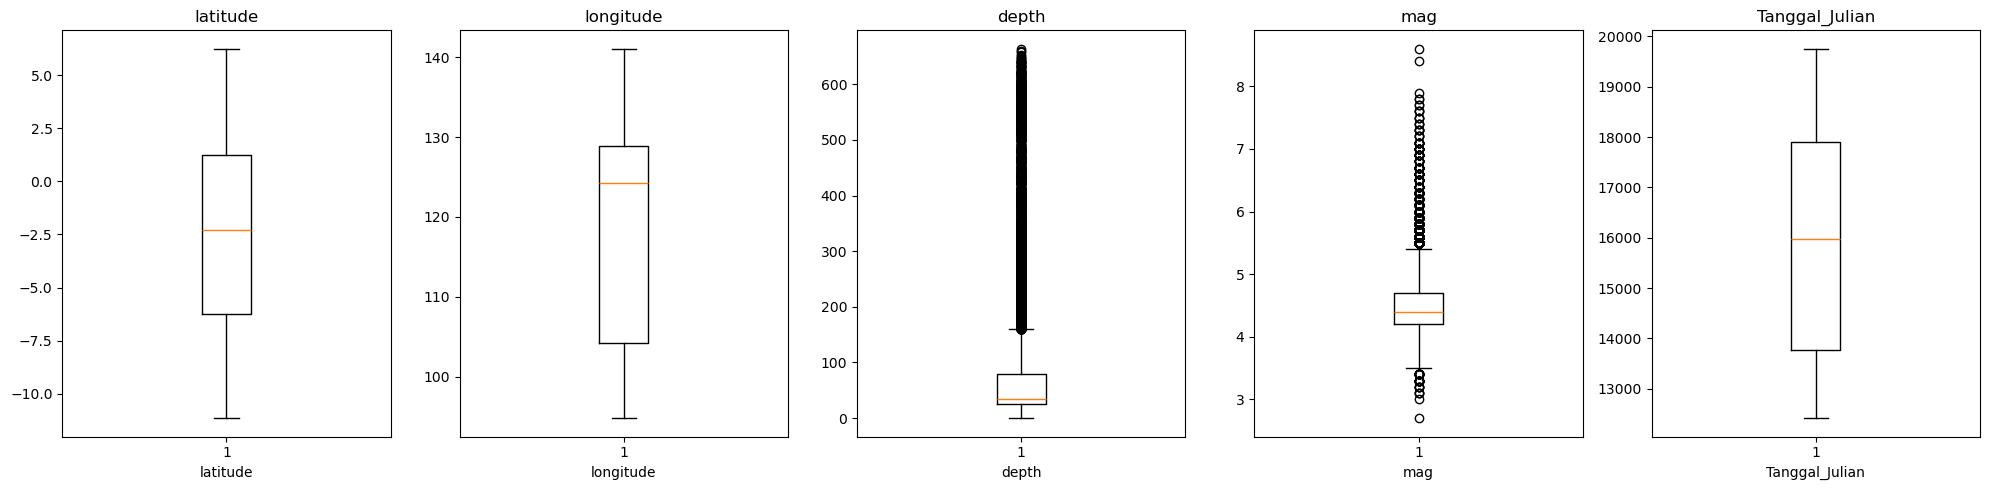

In [9]:
multi_boxplot(df_indonesia, numeric_vars)

In [10]:
# Pengecekan normalitas setiap prediktor
from scipy.stats import shapiro
for column in df_indonesia.columns:
    stat, p = shapiro(df_indonesia[column])
    print(f'Shapiro-Wilk test for {column}:')
    print(f'Statistic={stat}, p-value={p}')
    if p > 0.05:
        print(f'Variabel {column} berdistribusi normal \n')
    else:
        print(f'Variabel {column} tidak berdistribusi normal \n')

Shapiro-Wilk test for latitude:
Statistic=0.9521986246109009, p-value=0.0
Variabel latitude tidak berdistribusi normal 

Shapiro-Wilk test for longitude:
Statistic=0.8885691165924072, p-value=0.0
Variabel longitude tidak berdistribusi normal 

Shapiro-Wilk test for depth:
Statistic=0.6364271640777588, p-value=0.0
Variabel depth tidak berdistribusi normal 

Shapiro-Wilk test for mag:
Statistic=0.9119805097579956, p-value=0.0
Variabel mag tidak berdistribusi normal 

Shapiro-Wilk test for Tanggal_Julian:
Statistic=0.9311691522598267, p-value=0.0
Variabel Tanggal_Julian tidak berdistribusi normal 



C:\Users\Umar\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [11]:
df_indonesia.head()

,latitude,longitude,depth,mag,Tanggal_Julian
0,-0.878,119.896,70.0,4.4,12418.0
1,-6.156,113.730,588.6,4.9,12418.0
2,-8.310,115.788,44.5,5.8,12418.0
3,-8.086,118.263,180.8,4.3,12418.0
4,-1.960,139.145,60.0,4.4,12419.0


In [46]:
X=df_indonesia.drop(['mag'],axis=1)
y=df_indonesia['mag']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled[:5])

[[0.73333755 0.72290878 0.14404979 0.28438991]
 [0.54064159 0.89678606 0.01517911 0.32147239]
 [0.76842547 0.68708581 0.09137826 0.81676892]
 [0.75199167 0.73613029 0.01494232 0.93851397]
 [0.76963342 0.67685315 0.09153005 0.41635992]]


In [14]:
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
# Define the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 6],
    'min_samples_leaf': [2, 4, 8]
}

# Perform GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=3).fit(X_train_scaled, y_train)

print("Hyperparameter terbaik: ", grid_search.best_params_)
print("Score terbaik: ", grid_search.best_score_)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
Hyperparameter terbaik:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 300}
Score terbaik:  0.12349821049555436


In [15]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
71,29.821995,0.297692,1.002240,0.082224,20,sqrt,8,6,300,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.127848,0.122292,0.120355,0.123498,0.003176,1
68,30.619424,0.319932,1.086063,0.111699,20,sqrt,8,10,300,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.127848,0.122292,0.120355,0.123498,0.003176,1
65,29.190562,0.833287,0.953785,0.002332,20,sqrt,8,5,300,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.127848,0.122292,0.120355,0.123498,0.003176,1
62,28.845953,0.366563,0.904755,0.009966,20,sqrt,8,2,300,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.127848,0.122292,0.120355,0.123498,0.003176,1
107,28.824519,0.737092,0.971498,0.067364,30,sqrt,8,6,300,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",0.127908,0.121915,0.120471,0.123431,0.003220,5


In [16]:
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
# Define the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 6],
    'min_samples_leaf': [2, 4, 8]
}

# Define the scoring metrics
scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'mape': make_scorer(mean_absolute_percentage_error),
    'r2': make_scorer(r2_score)
}

# Perform GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=3, scoring=scoring, refit='r2').fit(X_train_scaled, y_train)

print("Hyperparameter terbaik: ", grid_search.best_params_)
print("Score terbaik: ", grid_search.best_score_)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
Hyperparameter terbaik:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 300}
Score terbaik:  0.12349821049555436


In [17]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_r2').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split2_test_mape,mean_test_mape,std_test_mape,rank_test_mape,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
71,28.728837,0.121672,0.919292,0.012690,20,sqrt,8,6,300,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.063691,0.063536,0.000255,142,0.127848,0.122292,0.120355,0.123498,0.003176,1
68,28.291863,0.200514,0.910682,0.012610,20,sqrt,8,10,300,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.063691,0.063536,0.000255,142,0.127848,0.122292,0.120355,0.123498,0.003176,1
65,28.197390,0.193327,0.935530,0.036287,20,sqrt,8,5,300,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.063691,0.063536,0.000255,142,0.127848,0.122292,0.120355,0.123498,0.003176,1
62,28.101535,0.325012,0.910514,0.008565,20,sqrt,8,2,300,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.063691,0.063536,0.000255,142,0.127848,0.122292,0.120355,0.123498,0.003176,1
107,28.844000,0.110056,0.923869,0.008827,30,sqrt,8,6,300,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",...,0.063682,0.063535,0.000245,147,0.127908,0.121915,0.120471,0.123431,0.003220,5


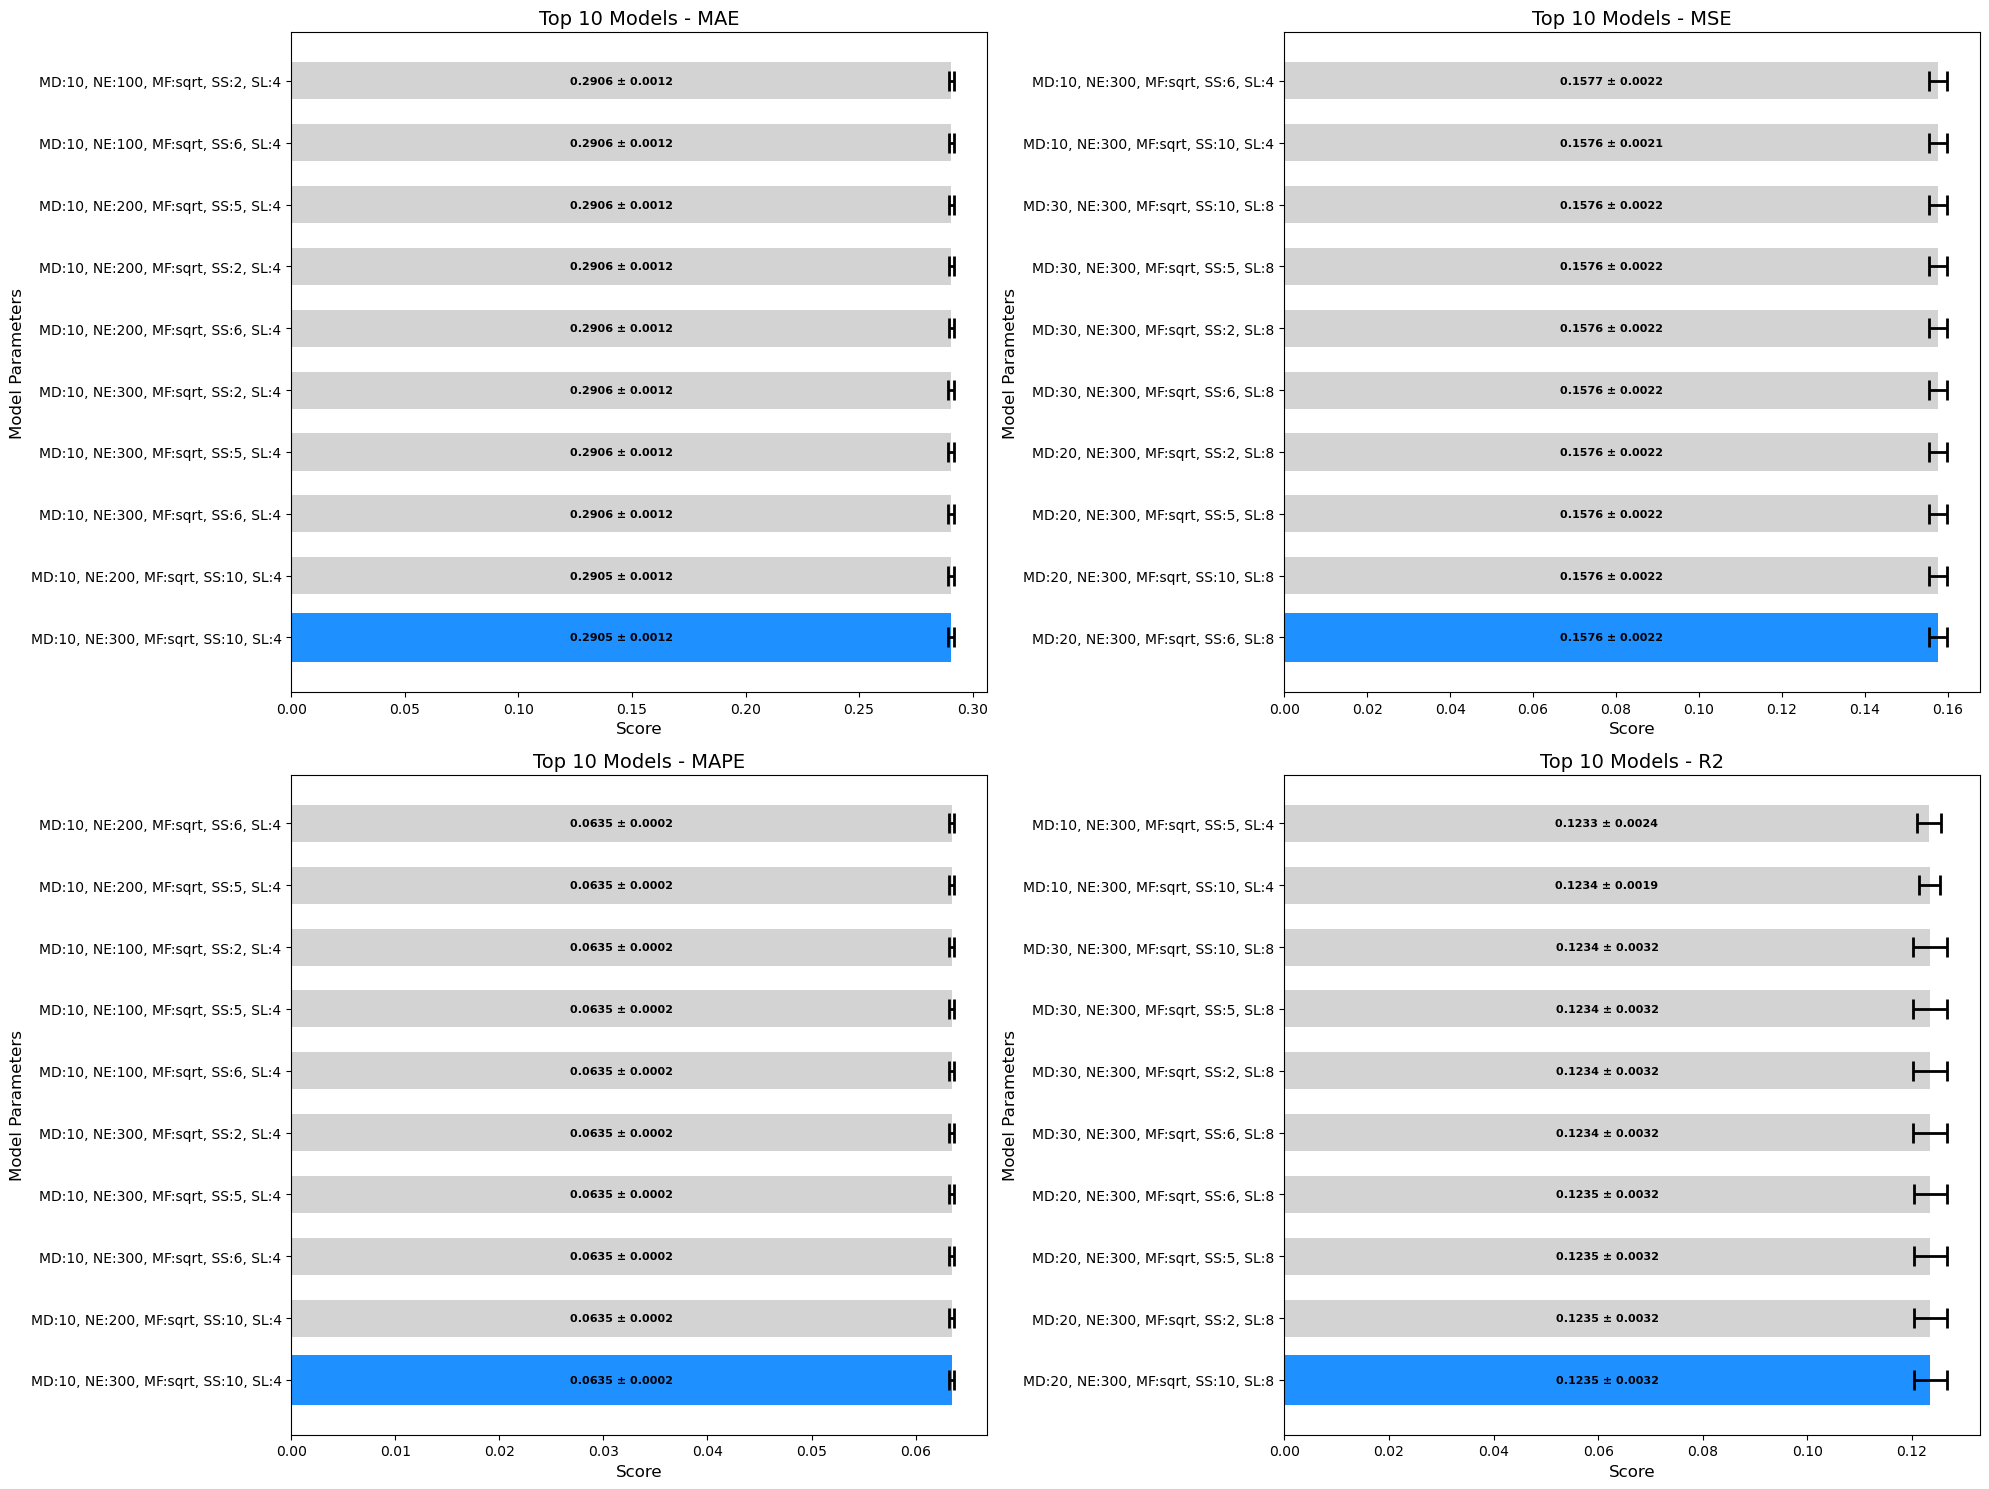

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_top_10(cv_results, metric, ax):
    # Sort results by the metric
    sorted_results = pd.DataFrame(cv_results).sort_values(f'mean_test_{metric}', ascending=False if metric == 'r2' else True)
    top_10 = sorted_results.head(10)

    # Extract means and stds
    means = top_10[f'mean_test_{metric}']
    stds = top_10[f'std_test_{metric}']

    # Create labels for each model with parameters
    labels = [f"MD:{p['param_max_depth']}, NE:{p['param_n_estimators']}, MF:{p['param_max_features']}, SS:{p['param_min_samples_split']}, SL:{p['param_min_samples_leaf']}" 
              for _, p in top_10.iterrows()]

    # Create color and size arrays
    colors = ['#1E90FF' if i == 0 else '#D3D3D3' for i in range(10)]  # Bright blue for best, light grey for others
    bar_heights = [0.8 if i == 0 else 0.6 for i in range(10)]  # Larger bar for best model

    # Plot
    for i, (mean, std, color, height) in enumerate(zip(means, stds, colors, bar_heights)):
        ax.barh(i, mean, height=height, color=color, edgecolor='none')
        ax.errorbar(mean, i, xerr=std, capsize=7, color='black', 
                    elinewidth=2, capthick=2, fmt='none', zorder=10)
        
        # Add mean ± std text inside the bar
        ax.text(mean/2, i, f'{mean:.4f} ± {std:.4f}', 
                va='center', ha='center', fontweight='bold', fontsize=8, color='black')

    ax.set_yticks(range(10))
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_title(f'Top 10 Models - {metric.upper()}', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Model Parameters', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Create the plot
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.ravel()  # Flatten the 2x2 array to 1D for easier indexing

metrics = ['mae', 'mse', 'mape', 'r2']

for i, metric in enumerate(metrics):
    plot_top_10(grid_search.cv_results_, metric, axs[i])

plt.tight_layout()
plt.show()

In [19]:
modelRF = RandomForestRegressor(max_depth=grid_search.best_params_["max_depth"],
                                 max_features=grid_search.best_params_["max_features"],
                                 min_samples_leaf=grid_search.best_params_["min_samples_leaf"],
                                 min_samples_split=grid_search.best_params_["min_samples_split"],
                                 n_estimators=grid_search.best_params_["n_estimators"],
                                 random_state=42)
modelRF.fit(X_train_scaled, y_train)

# Evaluate model on the testing set
y_pred = modelRF.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# Prepare data for table
metrics_data = pd.DataFrame([["Random Forest", mse, mae, mape, r2]], columns=["Model", "MSE", "MAE", "MAPE (%)", "R^2"])
print(metrics_data)

           Model      MSE       MAE  MAPE (%)       R^2
0  Random Forest  0.14881  0.283174  6.215471  0.138399


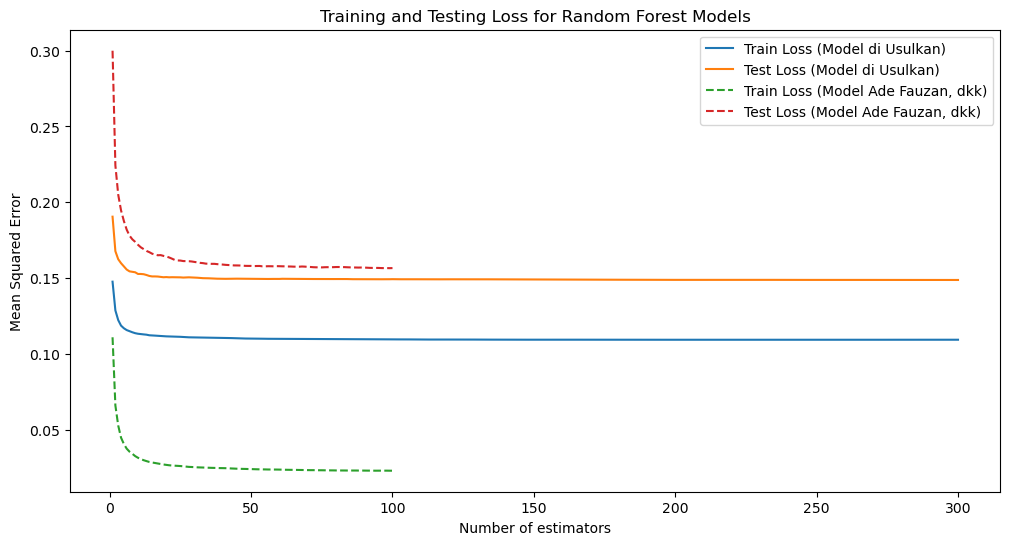

                              Model       MSE       MAE  MAPE (%)       R^2
0       Random Forest (Grid Search)  0.148810  0.283174  6.215471  0.138399
1  Random Forest (n_estimators=100)  0.156649  0.292413  6.438097  0.093009


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model 1: Model dengan parameter hasil grid search
modelRF1 = RandomForestRegressor(max_depth=grid_search.best_params_["max_depth"],
                                 max_features=grid_search.best_params_["max_features"],
                                 min_samples_leaf=grid_search.best_params_["min_samples_leaf"],
                                 min_samples_split=grid_search.best_params_["min_samples_split"],
                                 n_estimators=grid_search.best_params_["n_estimators"],
                                 random_state=42)

# Model 2: Model dengan hanya n_estimators=100
modelRF2 = RandomForestRegressor(n_estimators=100, random_state=42)

# List untuk menyimpan loss
train_loss1, test_loss1 = [], []
train_loss2, test_loss2 = [], []

# Fungsi untuk menghitung dan menyimpan loss
def calculate_loss(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    return train_mse, test_mse

# Melatih model dan menghitung loss
for i in range(1, modelRF1.n_estimators + 1):
    modelRF1.set_params(n_estimators=i)
    modelRF1.fit(X_train_scaled, y_train)
    train_mse, test_mse = calculate_loss(modelRF1, X_train_scaled, y_train, X_test_scaled, y_test)
    train_loss1.append(train_mse)
    test_loss1.append(test_mse)

for i in range(1, 101):  # for modelRF2 with 100 estimators
    modelRF2.set_params(n_estimators=i)
    modelRF2.fit(X_train_scaled, y_train)
    train_mse, test_mse = calculate_loss(modelRF2, X_train_scaled, y_train, X_test_scaled, y_test)
    train_loss2.append(train_mse)
    test_loss2.append(test_mse)

# Membuat grafik
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss1) + 1), train_loss1, label='Train Loss (Model di Usulkan)')
plt.plot(range(1, len(test_loss1) + 1), test_loss1, label='Test Loss (Model di Usulkan)')
plt.plot(range(1, 101), train_loss2, '--', label='Train Loss (Model Ade Fauzan, dkk)')  # Changed to dashed line
plt.plot(range(1, 101), test_loss2, '--', label='Test Loss (Model Ade Fauzan, dkk)')  # Changed to dashed line
plt.xlabel('Number of estimators')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss for Random Forest Models')
plt.legend()
plt.show()

# Evaluasi kedua model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    return mse, mae, mape, r2

mse1, mae1, mape1, r21 = evaluate_model(modelRF1, X_train_scaled, y_train, X_test_scaled, y_test)
mse2, mae2, mape2, r22 = evaluate_model(modelRF2, X_train_scaled, y_train, X_test_scaled, y_test)

# Menyiapkan data untuk tabel
metrics_data = pd.DataFrame([
    ["Random Forest (Grid Search)", mse1, mae1, mape1, r21],
    ["Random Forest (n_estimators=100)", mse2, mae2, mape2, r22]
], columns=["Model", "MSE", "MAE", "MAPE (%)", "R^2"])

print(metrics_data)

Index(['latitude', 'longitude', 'depth', 'mag', 'Tanggal_Julian'], dtype='object')
     Range  Data Size       MSE        R2       MAE      MAPE
0    2.5-9      35495  0.148834  0.138257  0.283188  6.215742
1  3.0-6.0      35237  0.130778  0.140049  0.276660  6.113081
2  4.0-6.0      33987  0.115902  0.138189  0.261258  5.701456
3  4.0-5.0      31170  0.065302  0.087550  0.209514  4.742312


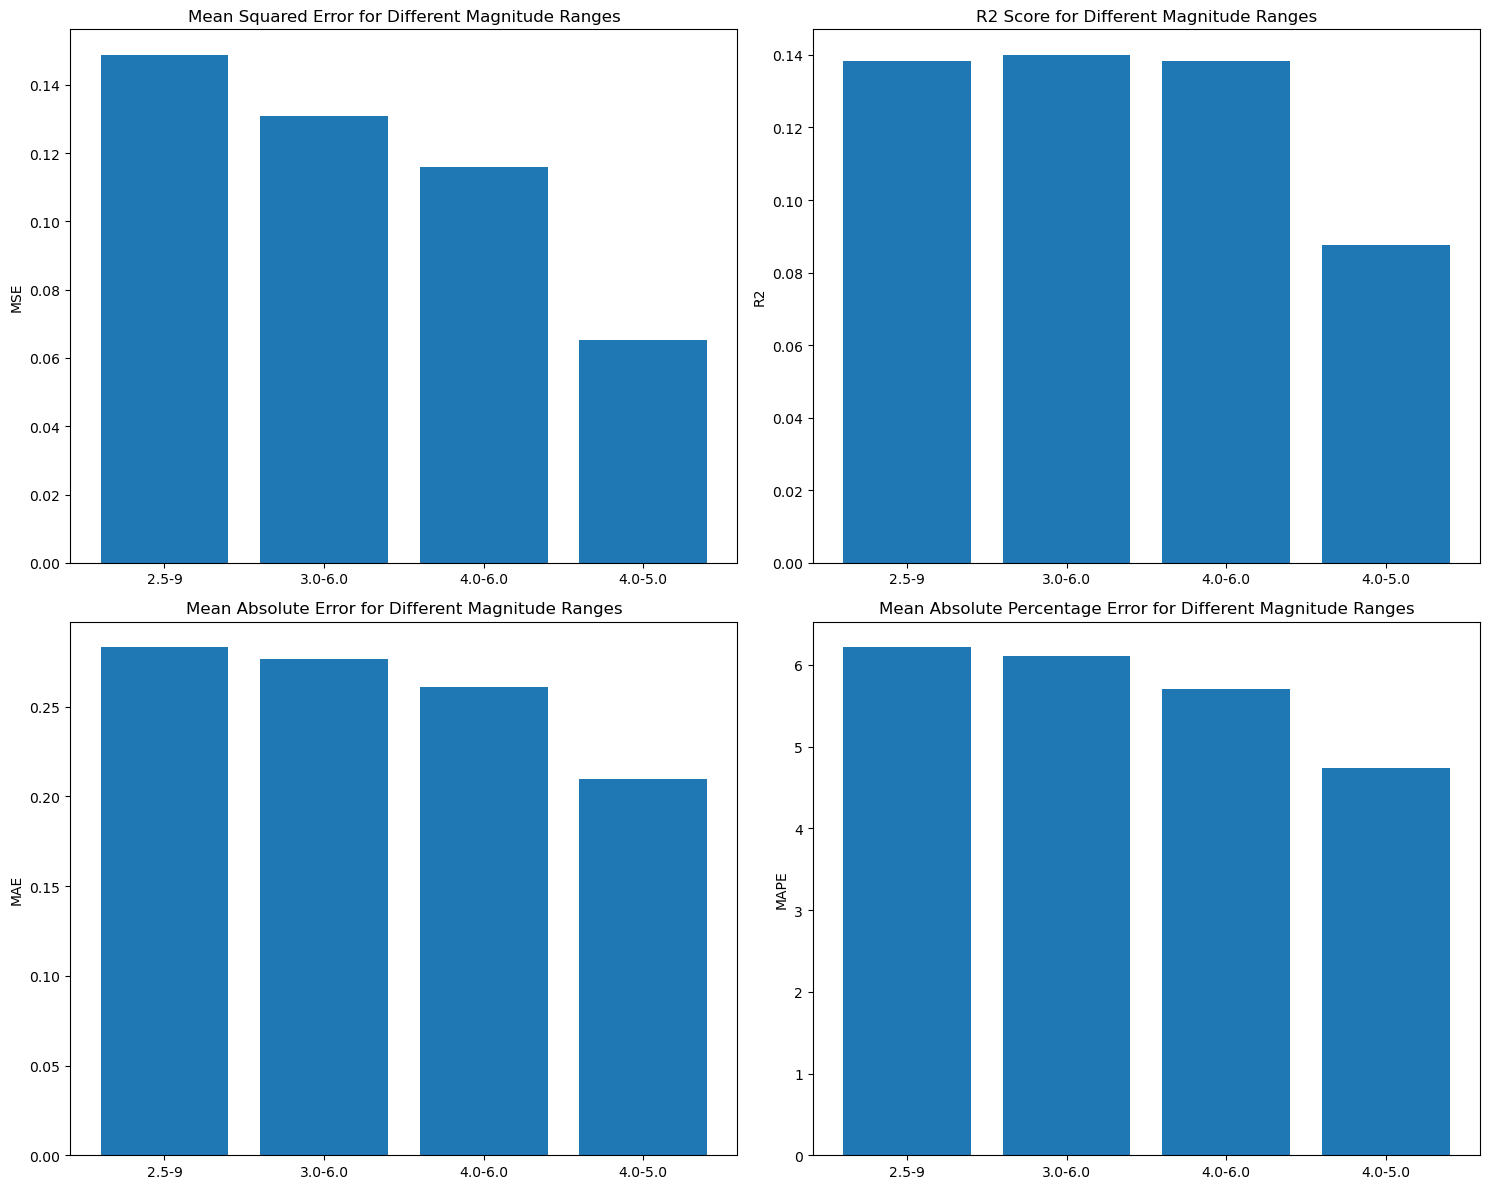

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Periksa nama kolom dalam DataFrame
print(df_indonesia.columns)

# Ganti 'mag' dengan nama kolom yang sesuai untuk magnitude dalam DataFrame Anda
magnitude_column = 'mag'  # Ganti dengan nama kolom yang benar jika berbeda

# Fungsi untuk memfilter data berdasarkan range magnitude
def filter_data(df, min_mag, max_mag):
    return df[(df[magnitude_column] >= min_mag) & (df[magnitude_column] <= max_mag)]

# Fungsi untuk menghitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi untuk melatih dan mengevaluasi model
def train_evaluate(X_train, X_test, y_train, y_test, best_params):
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mse, r2, mae, mape

# Parameter terbaik dari hyperparameter tuning
best_params = {
    'max_depth': 20, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 8, 
    'min_samples_split': 2, 
    'n_estimators': 300,
}

# Daftar range magnitude untuk diuji
mag_ranges = [
    (2.5, 9),
    (3.0, 6.0),
    (4.0, 6.0),
    (4.0, 5.0)
]

results = []
for min_mag, max_mag in mag_ranges:
    # Filter data
    df_filtered = filter_data(df_indonesia, min_mag, max_mag)
    
    # Pisahkan fitur dan target
    X = df_filtered.drop(magnitude_column, axis=1)
    y = df_filtered[magnitude_column]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train dan evaluasi model
    mse, r2, mae, mape = train_evaluate(X_train, X_test, y_train, y_test, best_params)
    
    results.append({
        'Range': f'{min_mag}-{max_mag}',
        'Data Size': len(df_filtered),
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape
    })

# Tampilkan hasil
results_df = pd.DataFrame(results)
print(results_df)

# Visualisasi hasil
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['MSE', 'R2', 'MAE', 'MAPE']
titles = ['Mean Squared Error', 'R2 Score', 'Mean Absolute Error', 'Mean Absolute Percentage Error']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    row = i // 2
    col = i % 2
    axs[row, col].bar(results_df['Range'], results_df[metric])
    axs[row, col].set_title(f'{title} for Different Magnitude Ranges')
    axs[row, col].set_ylabel(metric)

plt.tight_layout()
plt.show()

In [24]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# # Define the XGBoost model
# xgb_model = xgb.XGBRegressor(random_state=42)
# param_grid = {"max_depth":    [3, 4, 5, 6],
#               "n_estimators": [500, 600, 700, 800],
#               "learning_rate": [0.001, 0.01, 0.05]}
# search = GridSearchCV(xgb_model, param_grid, cv=5).fit(X_train_scaled, y_train)

# # Define the scoring metrics
# scoring = {
#     'mae': make_scorer(mean_absolute_error),
#     'mse': make_scorer(mean_squared_error),
#     'mape': make_scorer(mean_absolute_percentage_error),
#     'r2': make_scorer(r2_score)
# }

# print("Hyperparameter terbaik: ", search.best_params_)
# print("Score terbaik: ", search.best_score_)

In [25]:
# pd.DataFrame(search.cv_results_).sort_values('rank_test_score')

In [26]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# # Define the XGBoost model
# xgb_model2 = xgb.XGBRegressor(random_state=42)
# param_grid2 = {"max_depth":    [3, 4, 5, 6],
#               "n_estimators": [400, 500, 600, 700],
#               "learning_rate": [0.001, 0.01, 0.1, 0.2],
#               "subsample" : [0.6, 0.8, 1.0],
#               "colsample_bytree" : [0.6, 0.8, 1.0],
#               "gamma" : [0, 0.1, 0.2, 0.3, 0.4]}

# search2 = GridSearchCV(xgb_model2, param_grid2, cv=5).fit(X_train_scaled, y_train)

# # Define the scoring metrics
# scoring = {
#     'mae': make_scorer(mean_absolute_error),
#     'mse': make_scorer(mean_squared_error),
#     'mape': make_scorer(mean_absolute_percentage_error),
#     'r2': make_scorer(r2_score)
# }

# print("Hyperparameter terbaik: ", search2.best_params_)
# print("Score terbaik: ", search2.best_score_)

In [27]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# # Define the XGBoost model
# xgb_model = xgb.XGBRegressor(random_state=42)
# param_grid = {"max_depth":    [3, 4, 5, 6],
#               "n_estimators": [500, 600, 700, 800],
#               "learning_rate": [0.001, 0.01, 0.05]}

# # Define the scoring metrics
# scoring = {
#     'mae': make_scorer(mean_absolute_error),
#     'mse': make_scorer(mean_squared_error),
#     'mape': make_scorer(mean_absolute_percentage_error),
#     'r2': make_scorer(r2_score)
# }
# search = GridSearchCV(xgb_model, param_grid, cv=5, scoring=scoring, refit='r2')
# search.fit(X_train_scaled, y_train)
# print("Hyperparameter terbaik: ", search.best_params_)
# print("Score terbaik: ", search.best_score_)

In [28]:
# pd.DataFrame(search.cv_results_)

In [29]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def plot_top_10(cv_results, metric, ax):
#     # Sort results by the metric
#     sorted_results = pd.DataFrame(cv_results).sort_values(f'mean_test_{metric}', ascending=False if metric == 'r2' else True)
#     top_10 = sorted_results.head(10)

#     # Extract means and stds
#     means = top_10[f'mean_test_{metric}']
#     stds = top_10[f'std_test_{metric}']

#     # Create labels for each model with parameters
#     labels = [f"MD:{p['param_max_depth']}, NE:{p['param_n_estimators']}, LR:{p['param_learning_rate']}" 
#               for _, p in top_10.iterrows()]

#     # Create color and size arrays
#     colors = ['#1E90FF' if i == 0 else '#D3D3D3' for i in range(10)]  # Bright blue for best, light grey for others
#     bar_heights = [0.8 if i == 0 else 0.6 for i in range(10)]  # Larger bar for best model

#     # Plot
#     for i, (mean, std, color, height) in enumerate(zip(means, stds, colors, bar_heights)):
#         ax.barh(i, mean, height=height, color=color, edgecolor='none')
#         ax.errorbar(mean, i, xerr=std, capsize=7, color='black', 
#                     elinewidth=2, capthick=2, fmt='none', zorder=10)
        
#         # Add mean ± std text inside the bar
#         ax.text(mean/2, i, f'{mean:.4f} ± {std:.4f}', 
#                 va='center', ha='center', fontweight='bold', fontsize=8, color='black')

#     ax.set_yticks(range(10))
#     ax.set_yticklabels(labels, fontsize=8)
#     ax.set_title(f'Top 10 Models - {metric.upper()}', fontsize=14)
#     ax.set_xlabel('Score', fontsize=12)
#     ax.set_ylabel('Model Parameters', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)

# # Create the plot
# fig, axs = plt.subplots(2, 2, figsize=(20, 15))
# axs = axs.ravel()  # Flatten the 2x2 array to 1D for easier indexing

# metrics = ['mae', 'mse', 'mape', 'r2']

# for i, metric in enumerate(metrics):
#     plot_top_10(search.cv_results_, metric, axs[i])

# plt.tight_layout()
# plt.show()

In [30]:
# # Create XGBRegressor model
# modelXGB1 = xgb.XGBRegressor(learning_rate=search.best_params_["learning_rate"],
#                          n_estimators=search.best_params_["n_estimators"],
#                          max_depth=search.best_params_["max_depth"],
#                          random_state=42)

# # Fit the model
# modelXGB1.fit(X_train_scaled, y_train)

# # Make predictions
# y_train_pred = modelXGB1.predict(X_train_scaled)
# y_test_pred = modelXGB1.predict(X_test_scaled)

# # Evaluate XGBoost model
# mse_xgb = mean_squared_error(y_test, y_test_pred)
# mae_xgb = mean_absolute_error(y_test, y_test_pred)
# mape_xgb = mean_absolute_percentage_error(y_test, y_test_pred) * 100
# r2_xgb = r2_score(y_test, y_test_pred)

# print("XGBoost:")
# print("MSE:", mse_xgb)
# print("MAE:", mae_xgb)
# print("MAPE:", mape_xgb)
# print("R^2:", r2_xgb)



In [31]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Model 1: XGBoost dengan hyperparameter pertama
# xgb1 = XGBRegressor(learning_rate=search.best_params_["learning_rate"],
#                          n_estimators=search.best_params_["n_estimators"],
#                          max_depth=search.best_params_["max_depth"],
#                          random_state=42)

# # Model 2: XGBoost dengan hyperparameter kedua
# xgb2 = XGBRegressor(learning_rate=search2.best_params_["learning_rate"],
#                          n_estimators=search2.best_params_["n_estimators"],
#                          max_depth=search2.best_params_["max_depth"],
#                          subsample=search2.best_params_["subsample"],
#                          colsample_bytree=search2.best_params_["colsample_bytree"],
#                          gamma=search2.best_params_["gamma"],
#                          random_state=42
# )

# # List untuk menyimpan loss
# train_loss1, test_loss1 = [], []
# train_loss2, test_loss2 = [], []

# # Fungsi untuk menghitung dan menyimpan loss
# def calculate_loss(model, X_train, y_train, X_test, y_test):
#     train_pred = model.predict(X_train)
#     test_pred = model.predict(X_test)
#     train_mse = mean_squared_error(y_train, train_pred)
#     test_mse = mean_squared_error(y_test, test_pred)
#     return train_mse, test_mse

# # Melatih model dan menghitung loss
# for i in range(1, 1001):  # untuk 1000 estimators
#     xgb1.set_params(n_estimators=i)
#     xgb1.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
#     train_mse, test_mse = calculate_loss(xgb1, X_train_scaled, y_train, X_test_scaled, y_test)
#     train_loss1.append(train_mse)
#     test_loss1.append(test_mse)

# for i in range(1, 1001):  # untuk 1000 estimators
#     xgb2.set_params(n_estimators=i)
#     xgb2.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
#     train_mse, test_mse = calculate_loss(xgb2, X_train_scaled, y_train, X_test_scaled, y_test)
#     train_loss2.append(train_mse)
#     test_loss2.append(test_mse)

# # Membuat grafik
# plt.figure(figsize=(12, 6))
# plt.plot(range(1, 1001), train_loss1, label='Train Loss (Model di Usulkan)')
# plt.plot(range(1, 1001), test_loss1, label='Test Loss (Model di Usulkan)')
# plt.plot(range(1, 1001), train_loss2, '--', label='Train Loss (Model Ari Wibowo)')  # Garis putus-putus
# plt.plot(range(1, 1001), test_loss2, '--', label='Test Loss (Model Ari Wibowo)')   # Garis putus-putus
# plt.xlabel('Number of estimators')
# plt.ylabel('Mean Squared Error')
# plt.title('Training and Testing Loss for XGBoost Models')
# plt.legend()
# plt.show()

# # Evaluasi kedua model
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
#     r2 = r2_score(y_test, y_pred)
#     return mse, mae, mape, r2

# mse1, mae1, mape1, r21 = evaluate_model(xgb1, X_train_scaled, y_train, X_test_scaled, y_test)
# mse2, mae2, mape2, r22 = evaluate_model(xgb2, X_train_scaled, y_train, X_test_scaled, y_test)

# # Menyiapkan data untuk tabel
# metrics_data = pd.DataFrame([
#     ["XGBoost (Model 1)", mse1, mae1, mape1, r21],
#     ["XGBoost (Model 2)", mse2, mae2, mape2, r22]
# ], columns=["Model", "MSE", "MAE", "MAPE (%)", "R^2"])

# print(metrics_data)

In [48]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [49]:
#MODEL MLP 1
model_mlp_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Correct way to define input shape
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_mlp_1.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

history_1 = model_mlp_1.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, y_test), verbose=1,
                          callbacks=[early_stopping])


Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7632 - mean_absolute_error: 0.7579 - val_loss: 0.1750 - val_mean_absolute_error: 0.3081
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1846 - mean_absolute_error: 0.3144 - val_loss: 0.1748 - val_mean_absolute_error: 0.3141
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1747 - mean_absolute_error: 0.3080 - val_loss: 0.1722 - val_mean_absolute_error: 0.2967
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1763 - mean_absolute_error: 0.3056 - val_loss: 0.1790 - val_mean_absolute_error: 0.3234
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1743 - mean_absolute_error: 0.3065 - val_loss: 0.1701 - val_mean_absolute_error: 0.2987
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1769 - mean_absolute_error: 0.3093 - val_loss: 0.1703 - val_mean_absolute_error: 0.3042
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1792 - mean_absolute_error: 0.3112 - v

In [50]:
# MLP MODEL 2
model_mlp_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_mlp_2.compile(optimizer=tf.keras.optimizers.RMSprop(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

history_2 = model_mlp_2.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, y_test), verbose=1,
                          callbacks=[early_stopping])

Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.8691 - mean_absolute_error: 2.2252 - val_loss: 0.1719 - val_mean_absolute_error: 0.2967
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1773 - mean_absolute_error: 0.3086 - val_loss: 0.1705 - val_mean_absolute_error: 0.2952
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1728 - mean_absolute_error: 0.3059 - val_loss: 0.1690 - val_mean_absolute_error: 0.3005
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1763 - mean_absolute_error: 0.3097 - val_loss: 0.1957 - val_mean_absolute_error: 0.3504
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1803 - mean_absolute_error: 0.3111 - val_loss: 0.1692 - val_mean_absolute_error: 0.3029
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1771 - mean_absolute_error: 0.3052 - val_loss: 0.1746 - val_mean_absolute_error: 0.2949
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1743 - mean_absolute_error: 0.3063 - v

In [51]:
#MODEL MLP 3
model_mlp_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_mlp_3.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

history_3 = model_mlp_3.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, y_test), verbose=1,
                          callbacks=[early_stopping])

Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.9505 - mean_absolute_error: 1.7236 - val_loss: 0.1783 - val_mean_absolute_error: 0.3145
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1802 - mean_absolute_error: 0.3130 - val_loss: 0.1707 - val_mean_absolute_error: 0.2997
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1770 - mean_absolute_error: 0.3075 - val_loss: 0.1713 - val_mean_absolute_error: 0.2959
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1777 - mean_absolute_error: 0.3075 - val_loss: 0.1737 - val_mean_absolute_error: 0.3141
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1806 - mean_absolute_error: 0.3100 - val_loss: 0.1703 - val_mean_absolute_error: 0.2954
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1768 - mean_absolute_error: 0.3086 - val_loss: 0.1697 - val_mean_absolute_error: 0.2964
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1762 - mean_absolute_error: 0.3084 - v

In [52]:
#MODEL MLP 4
model_mlp_4 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_mlp_4.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

history_4 = model_mlp_4.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, y_test), verbose=1,
                          callbacks=[early_stopping])

Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6871 - mean_absolute_error: 0.4825 - val_loss: 0.1702 - val_mean_absolute_error: 0.3025
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1855 - mean_absolute_error: 0.3167 - val_loss: 0.1758 - val_mean_absolute_error: 0.2951
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1823 - mean_absolute_error: 0.3141 - val_loss: 0.1697 - val_mean_absolute_error: 0.2977
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1762 - mean_absolute_error: 0.3087 - val_loss: 0.1712 - val_mean_absolute_error: 0.3086
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1837 - mean_absolute_error: 0.3118 - val_loss: 0.1709 - val_mean_absolute_error: 0.2946
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1740 - mean_absolute_error: 0.3049 - val_loss: 0.1696 - val_mean_absolute_error: 0.3047
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1705 - mean_absolute_error: 0.3053 - v

In [53]:
#MODEL MLP 5
model_mlp_5 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_mlp_5.compile(optimizer=tf.keras.optimizers.RMSprop(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

history_5 = model_mlp_5.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, y_test), verbose=1,
                          callbacks=[early_stopping])

Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.9049 - mean_absolute_error: 0.6410 - val_loss: 0.2217 - val_mean_absolute_error: 0.3820
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2967 - mean_absolute_error: 0.4187 - val_loss: 0.1828 - val_mean_absolute_error: 0.2992
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2725 - mean_absolute_error: 0.3966 - val_loss: 0.1814 - val_mean_absolute_error: 0.3282
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2318 - mean_absolute_error: 0.3636 - val_loss: 0.1688 - val_mean_absolute_error: 0.2990
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2002 - mean_absolute_error: 0.3317 - val_loss: 0.1910 - val_mean_absolute_error: 0.3447
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1930 - mean_absolute_error: 0.3236 - val_loss: 0.2064 - val_mean_absolute_error: 0.3161
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1883 - mean_absolute_error: 0.3203 - v

In [54]:
#MODEL MLP 6
model_mlp_6 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_mlp_6.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

history_6 = model_mlp_6.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, y_test), verbose=1,
                          callbacks=[early_stopping])

Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 1.5448 - mean_absolute_error: 0.7530 - val_loss: 0.2699 - val_mean_absolute_error: 0.3748
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2468 - mean_absolute_error: 0.3752 - val_loss: 0.1689 - val_mean_absolute_error: 0.2992
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2369 - mean_absolute_error: 0.3678 - val_loss: 0.1702 - val_mean_absolute_error: 0.2953
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2280 - mean_absolute_error: 0.3591 - val_loss: 0.2008 - val_mean_absolute_error: 0.3118
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2147 - mean_absolute_error: 0.3463 - val_loss: 0.1710 - val_mean_absolute_error: 0.2944
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2014 - mean_absolute_error: 0.3313 - val_loss: 0.1974 - val_mean_absolute_error: 0.3538
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1936 - mean_absolute_error: 0.3228 - v

In [55]:
#MODEL MLP 7
model_mlp_7 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_mlp_7.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

history_7 = model_mlp_7.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, y_test), verbose=1,
                          callbacks=[early_stopping])

Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.7709 - mean_absolute_error: 0.8469 - val_loss: 0.4117 - val_mean_absolute_error: 0.5075
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2707 - mean_absolute_error: 0.3959 - val_loss: 0.1721 - val_mean_absolute_error: 0.2947
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2021 - mean_absolute_error: 0.3295 - val_loss: 0.1698 - val_mean_absolute_error: 0.2961
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1835 - mean_absolute_error: 0.3138 - val_loss: 0.1692 - val_mean_absolute_error: 0.2965
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1770 - mean_absolute_error: 0.3081 - val_loss: 0.1683 - val_mean_absolute_error: 0.3015
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1796 - mean_absolute_error: 0.3102 - val_loss: 0.1694 - val_mean_absolute_error: 0.3021
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1805 - mean_absolute_error: 0.3102 - v

In [56]:
#MODEL MLP 8
model_mlp_8 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_mlp_8.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

history_8 = model_mlp_8.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, y_test), verbose=1,
                          callbacks=[early_stopping])

Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.0528 - mean_absolute_error: 0.8993 - val_loss: 0.1993 - val_mean_absolute_error: 0.3107
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2583 - mean_absolute_error: 0.3820 - val_loss: 0.1722 - val_mean_absolute_error: 0.2958
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2106 - mean_absolute_error: 0.3410 - val_loss: 0.1684 - val_mean_absolute_error: 0.2974
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1856 - mean_absolute_error: 0.3151 - val_loss: 0.1686 - val_mean_absolute_error: 0.2988
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1783 - mean_absolute_error: 0.3103 - val_loss: 0.1687 - val_mean_absolute_error: 0.2983
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1815 - mean_absolute_error: 0.3096 - val_loss: 0.1711 - val_mean_absolute_error: 0.3102
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1758 - mean_absolute_error: 0.3069 - v

In [57]:
#MODEL MLP 9
model_mlp_9 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_mlp_9.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

history_9 = model_mlp_9.fit(X_train_scaled, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test_scaled, y_test), verbose=1,
                          callbacks=[early_stopping])

Epoch 1/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.9080 - mean_absolute_error: 1.0859 - val_loss: 0.1712 - val_mean_absolute_error: 0.3000
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2285 - mean_absolute_error: 0.3607 - val_loss: 0.1773 - val_mean_absolute_error: 0.2954
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2055 - mean_absolute_error: 0.3373 - val_loss: 0.1701 - val_mean_absolute_error: 0.3074
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1847 - mean_absolute_error: 0.3160 - val_loss: 0.1824 - val_mean_absolute_error: 0.3304
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1778 - mean_absolute_error: 0.3101 - val_loss: 0.1747 - val_mean_absolute_error: 0.3173
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1823 - mean_absolute_error: 0.3120 - val_loss: 0.1721 - val_mean_absolute_error: 0.3123
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1743 - mean_absolute_error: 0.3063 - v

222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


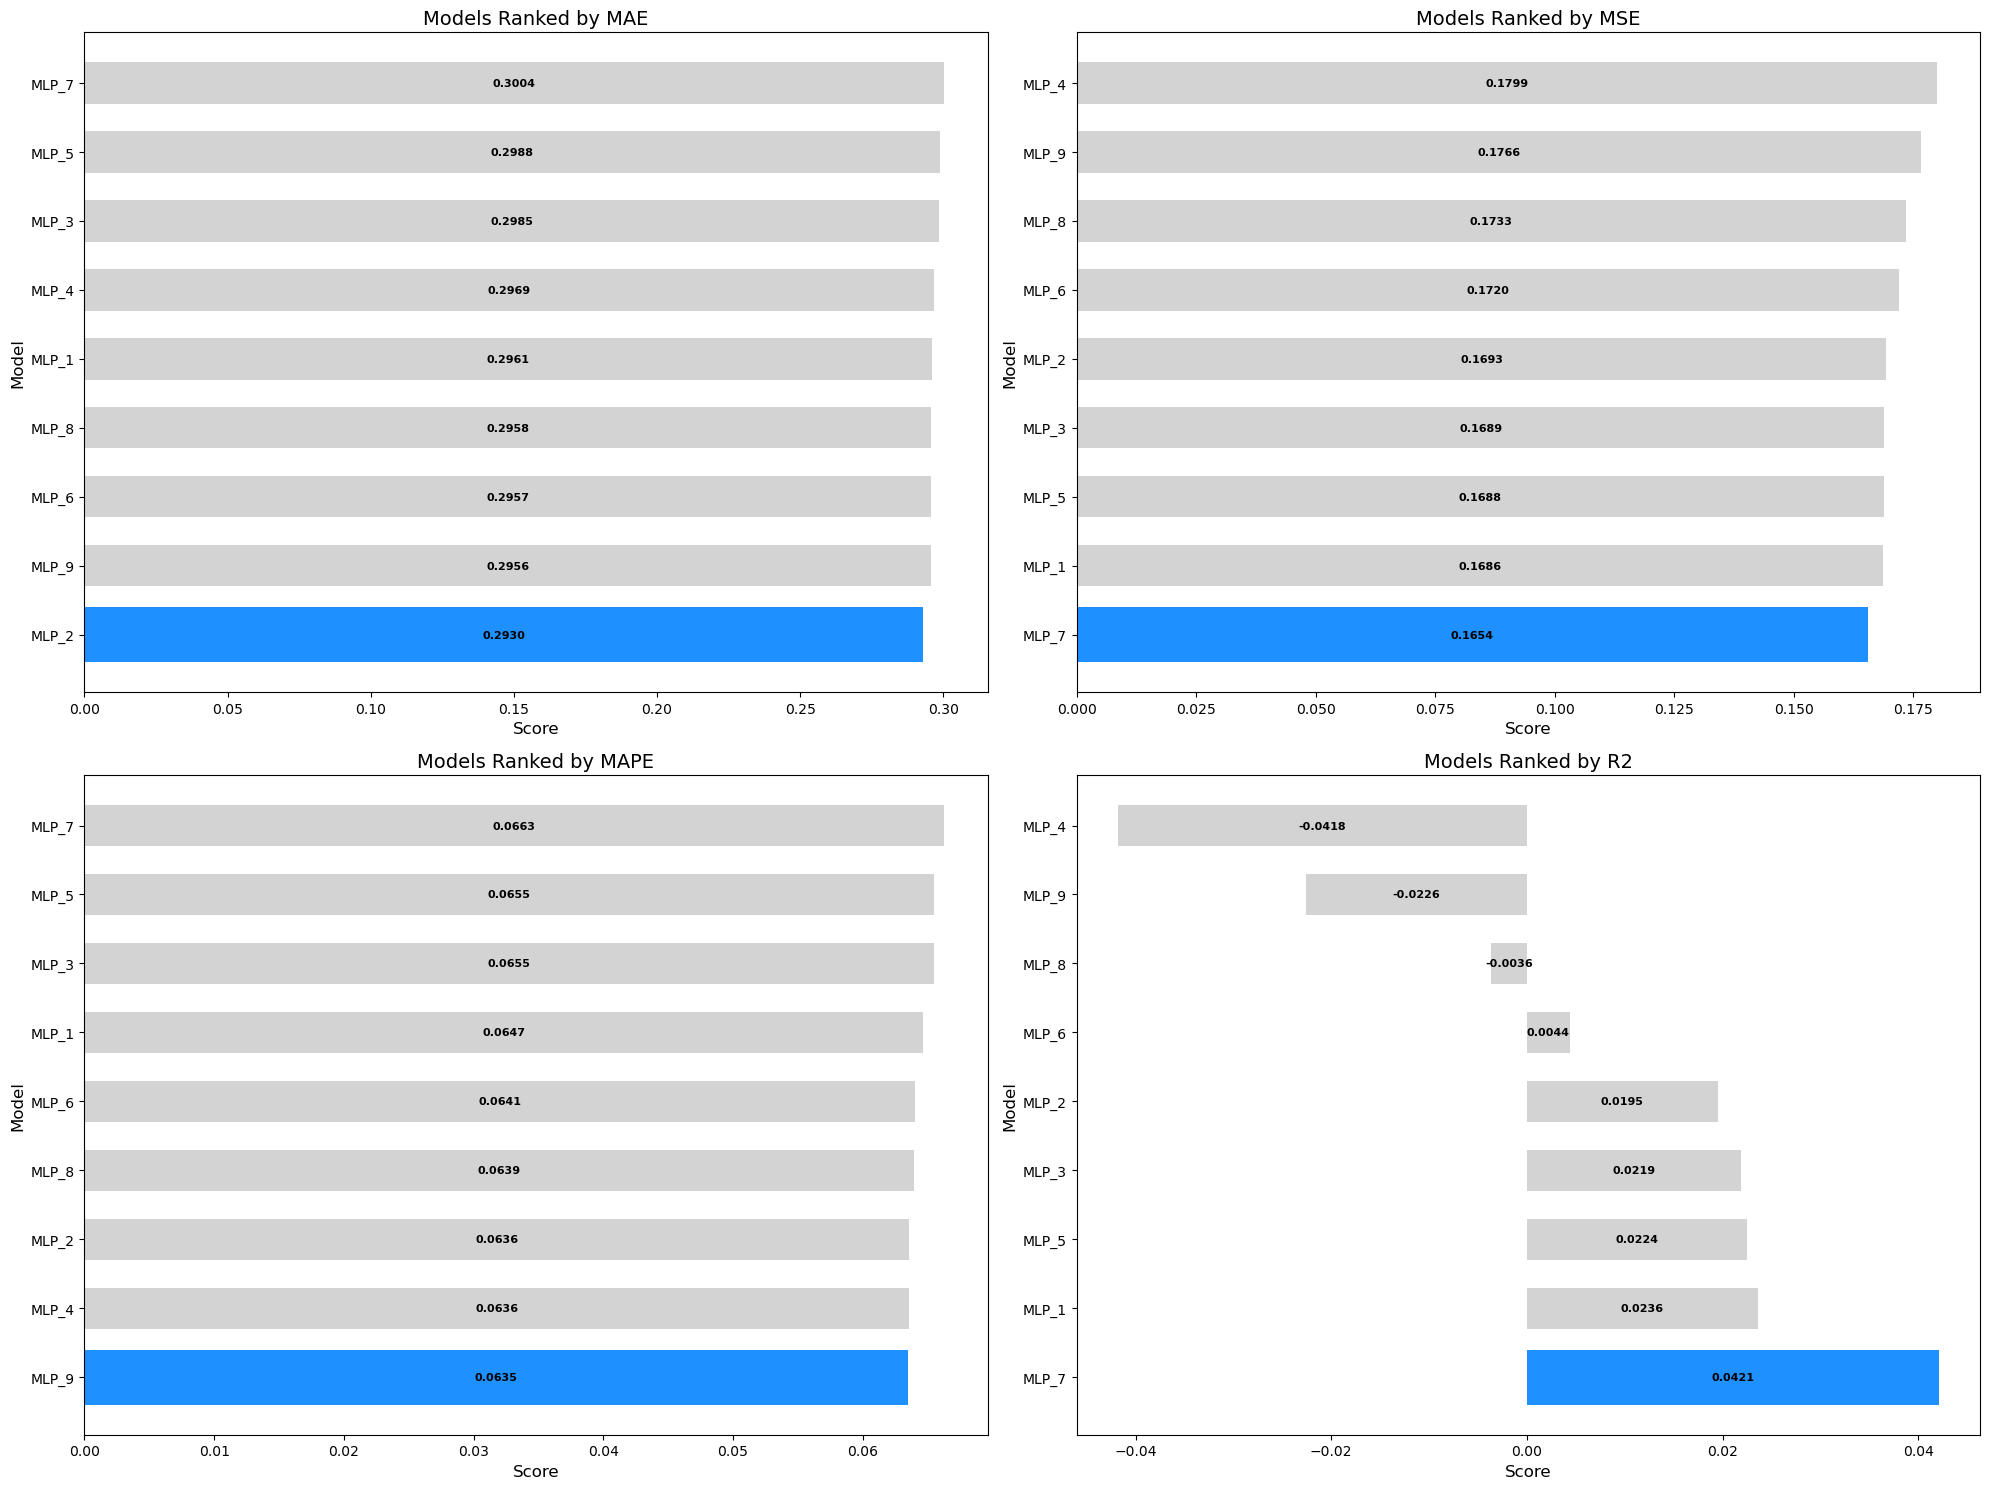

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'mae': mean_absolute_error(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mape': mean_absolute_percentage_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }

def plot_metric(df, metric, ax):
    # Sort by the metric
    df_sorted = df.sort_values(metric, ascending='r2' not in metric)
    
    means = df_sorted[metric]
    labels = df_sorted['model']
    
    colors = ['#1E90FF' if i == 0 else '#D3D3D3' for i in range(len(means))]
    bar_heights = [0.8 if i == 0 else 0.6 for i in range(len(means))]

    # Plot
    for i, (mean, color, height) in enumerate(zip(means, colors, bar_heights)):
        ax.barh(i, mean, height=height, color=color, edgecolor='none')
        
        # Add score text inside the bar
        ax.text(mean/2, i, f'{mean:.4f}', 
                va='center', ha='center', fontweight='bold', fontsize=8, color='black')

    ax.set_yticks(range(len(means)))
    ax.set_yticklabels(labels)
    ax.set_title(f'Models Ranked by {metric.upper()}', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Assuming you have 9 models named model_mlp_1 to model_mlp_9
models = [model_mlp_1, model_mlp_2, model_mlp_3, model_mlp_4, model_mlp_5, 
          model_mlp_6, model_mlp_7, model_mlp_8, model_mlp_9]

# Evaluate all models
model_scores = []
for i, model in enumerate(models, 1):
    scores = evaluate_model(model, X_test_scaled, y_test)
    scores['model'] = f'MLP_{i}'
    model_scores.append(scores)

df = pd.DataFrame(model_scores)

metrics = ['mae', 'mse', 'mape', 'r2']

# Create the plot
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.ravel()  # Flatten the 2x2 array to 1D for easier indexing

for i, metric in enumerate(metrics):
    plot_metric(df, metric, axs[i])

plt.tight_layout()
plt.show()

In [37]:
# Model terbaik
best_rf_model = modelRF
# best_xgb_model = modelXGB1
best_mlp_model = model_mlp_7

# X merupakan data asli
def get_prediction_result(X, scaler=scaler, rf_model=best_rf_model, mlp_model=best_mlp_model):
    X_scaled = scaler.transform(X)
    rf_prediction = rf_model.predict(X_scaled)
    mlp_prediction = mlp_model.predict(X_scaled)
    return [rf_prediction, mlp_prediction]

rf_prediction, mlp_prediction = get_prediction_result(X)
mlp_prediction_flat = mlp_prediction.reshape(-1)

1110/1110 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step


In [38]:
prediction_result = pd.DataFrame({
    'True Labels': y,
    'RF Prediction': rf_prediction,
    'MLP Prediction': mlp_prediction_flat
})

prediction_result.head(5)

,True Labels,RF Prediction,MLP Prediction
0,4.4,4.528251,4.558448
1,4.9,4.550309,4.612310
2,5.8,4.727605,4.455409
3,4.3,4.373757,4.436271
4,4.4,4.444662,4.470441


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

y_test = prediction_result['True Labels']
y_pred = prediction_result['MLP Prediction']

# Evaluasi Metriks
mse_mlp = mean_squared_error(y_test, y_pred)
mae_mlp = mean_absolute_error(y_test, y_pred)
mape_mlp = mean_absolute_percentage_error(y_test, y_pred) * 100
r2_mlp = r2_score(y_test, y_pred)

metrics_result = pd.DataFrame({
    'Model': ['MLP'],
    'MSE': [mse_mlp],
    'MAE': [mae_mlp],
    'MAPE': [mape_mlp],
    'R^2': [r2_mlp]
})
display(Markdown(metrics_result.to_markdown(index=False)))

| Model   |      MSE |      MAE |    MAPE |       R^2 |
|:--------|---------:|---------:|--------:|----------:|
| MLP     | 0.176088 | 0.314654 | 6.95539 | 0.0130056 |

In [40]:
import numpy as np
import pandas as pd

# Hitung error absolut untuk setiap model
prediction_result['RF Error'] = np.abs(prediction_result['True Labels'] - prediction_result['RF Prediction'])
prediction_result['MLP Error'] = np.abs(prediction_result['True Labels'] - prediction_result['MLP Prediction'])

# Tentukan threshold untuk error besar (misalnya, 90 persentil dari error)
error_threshold = np.percentile(prediction_result[['RF Error', 'MLP Error']].values, 90)

# Gabungkan prediction_result dengan fitur-fitur dari df_indonesia
full_result = pd.concat([df_indonesia[['latitude', 'longitude', 'depth', 'Tanggal_Julian']], prediction_result], axis=1)

# Filter data dengan error besar
large_errors = full_result[
    (full_result['RF Error'] > error_threshold) |
    (full_result['MLP Error'] > error_threshold)
]

# Urutkan berdasarkan error terbesar
large_errors = large_errors.sort_values(by=['RF Error', 'MLP Error'], ascending=False)

# Tampilkan hasil
print("Data dengan error prediksi besar:")
print(large_errors[['latitude', 'longitude', 'depth', 'Tanggal_Julian', 'True Labels', 'RF Prediction', 'MLP Prediction', 'RF Error', 'MLP Error']].head(10))
large_errors.to_csv('large_prediction_errors.csv', index=False)

Data dengan error prediksi besar:
       latitude  longitude   depth  Tanggal_Julian  True Labels  \
2027     2.0850     97.108   30.00         12870.0          8.6   
8923    -4.4380    101.367   34.00         13768.0          8.4   
33523   -7.0586    130.009  104.95         19366.0          7.6   
13351    2.3830     97.048   31.00         14705.0          7.8   
5055    -5.4730    128.131  397.00         13175.0          7.6   
8991    -2.6250    100.841   35.00         13768.0          7.9   
142     -4.0030    135.023   10.00         12455.0          7.3   
8712    -5.8590    107.419  280.00         13733.0          7.5   
14014   -3.4870    100.082   20.10         14907.0          7.8   
12817   -0.7200     99.867   81.00         14517.0          7.6   

       RF Prediction  MLP Prediction  RF Error  MLP Error  
2027        4.988098        4.558258  3.611902   4.041742  
8923        5.049739        4.690948  3.350261   3.709052  
33523       4.468477        4.495667  3.131523  

In [41]:
eror=pd.read_csv('large_prediction_errors.csv')
eror.head(10)

,latitude,longitude,depth,Tanggal_Julian,True Labels,RF Prediction,MLP Prediction,RF Error,MLP Error
0,2.0850,97.108,30.00,12870.0,8.6,4.988098,4.558258,3.611902,4.041742
1,-4.4380,101.367,34.00,13768.0,8.4,5.049739,4.690948,3.350261,3.709052
2,-7.0586,130.009,104.95,19366.0,7.6,4.468477,4.495667,3.131523,3.104333
3,2.3830,97.048,31.00,14705.0,7.8,4.882555,4.557978,2.917445,3.242022
4,-5.4730,128.131,397.00,13175.0,7.6,4.721190,4.421225,2.878810,3.178775
5,-2.6250,100.841,35.00,13768.0,7.9,5.070317,4.673514,2.829683,3.226486
6,-4.0030,135.023,10.00,12455.0,7.3,4.504848,4.484047,2.795152,2.815953
7,-5.8590,107.419,280.00,13733.0,7.5,4.739512,4.476126,2.760488,3.023874
8,-3.4870,100.082,20.10,14907.0,7.8,5.051787,4.696754,2.748213,3.103246
9,-0.7200,99.867,81.00,14517.0,7.6,4.922723,4.594432,2.677277,3.005568


C:\Users\Umar\AppData\Local\Temp\ipykernel_9904\3587219858.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  error_colormap = plt.cm.get_cmap('coolwarm')


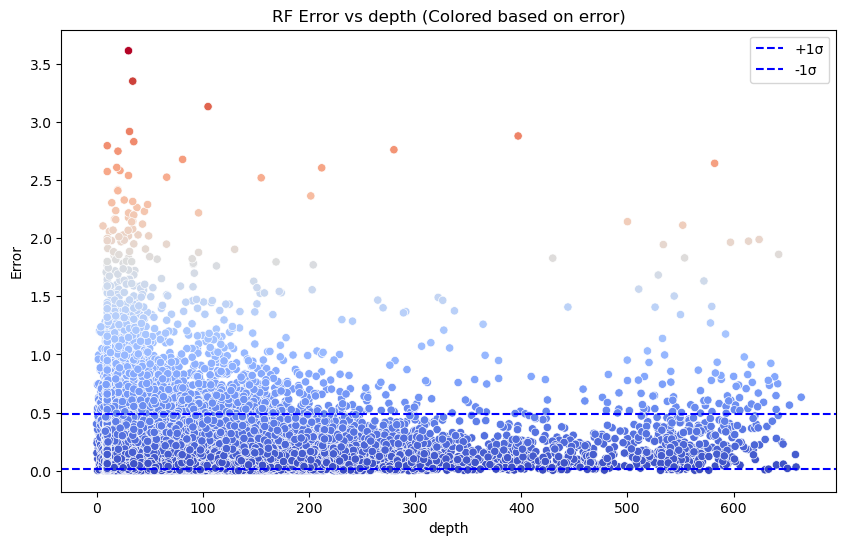

C:\Users\Umar\AppData\Local\Temp\ipykernel_9904\3587219858.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  error_colormap = plt.cm.get_cmap('coolwarm')


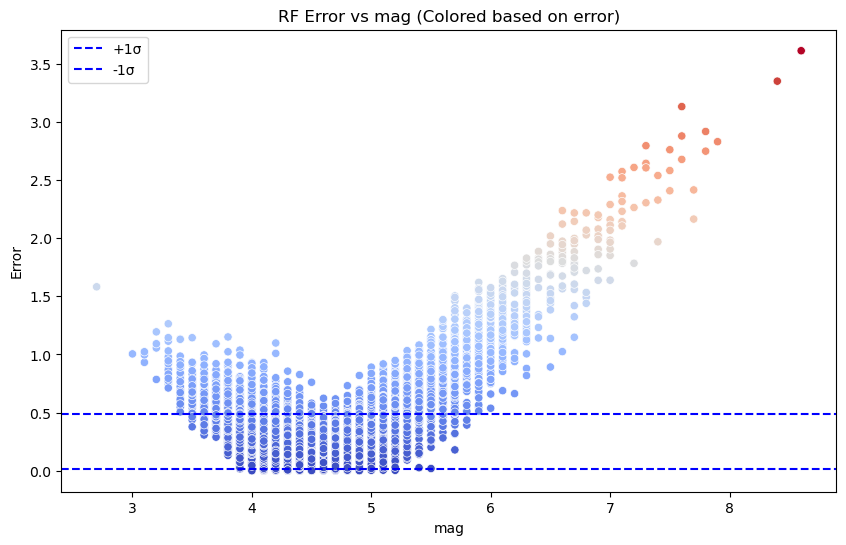

C:\Users\Umar\AppData\Local\Temp\ipykernel_9904\3587219858.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  error_colormap = plt.cm.get_cmap('coolwarm')


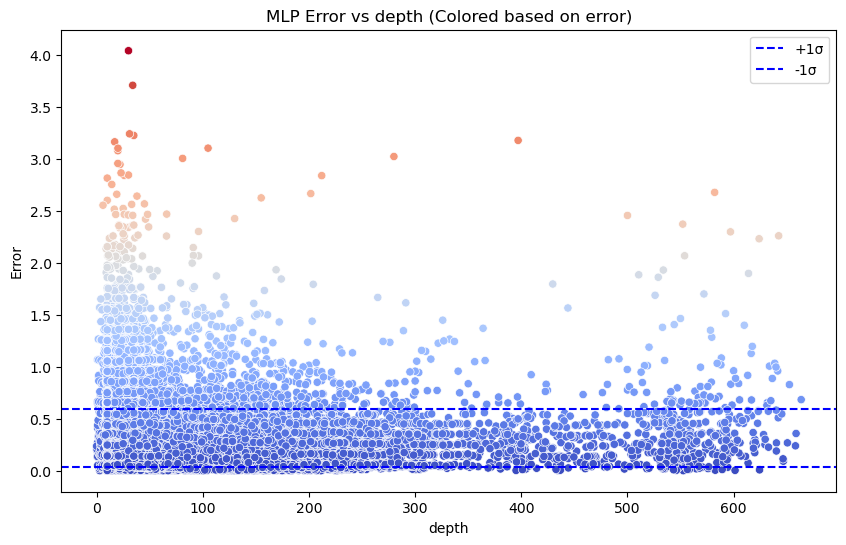

C:\Users\Umar\AppData\Local\Temp\ipykernel_9904\3587219858.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  error_colormap = plt.cm.get_cmap('coolwarm')


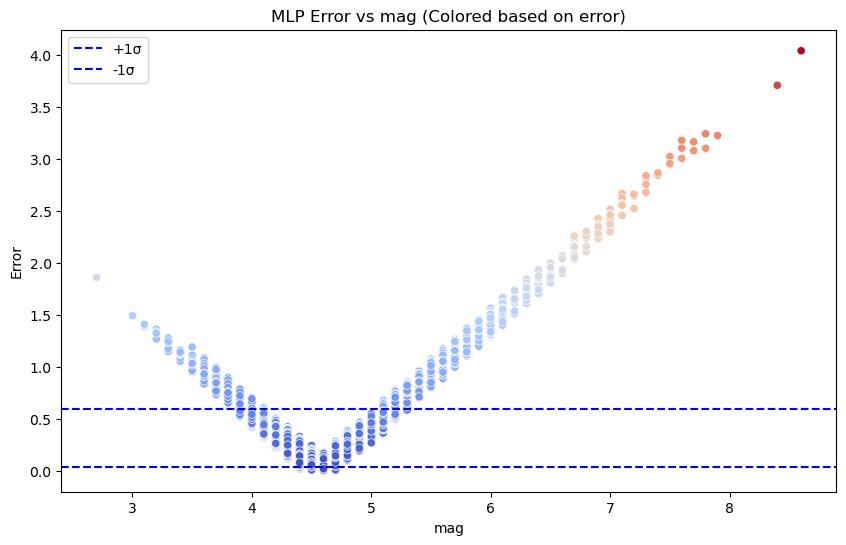


Statistik error untuk model RF:
count    35495.000000
mean         0.247888
std          0.236334
min          0.000014
25%          0.090375
50%          0.192333
75%          0.331780
max          3.611902
Name: RF Error, dtype: float64

Standar Deviasi Error untuk model RF: 0.2363

Statistik error untuk model MLP:
count    35495.000000
mean         0.314654
std          0.277638
min          0.000041
25%          0.133983
50%          0.257243
75%          0.433317
max          4.041742
Name: MLP Error, dtype: float64

Standar Deviasi Error untuk model MLP: 0.2776

Data dengan error prediksi besar telah disimpan dalam 'large_prediction_errors.csv'


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Hitung error absolut untuk setiap model
prediction_result['RF Error'] = np.abs(prediction_result['True Labels'] - prediction_result['RF Prediction'])
prediction_result['MLP Error'] = np.abs(prediction_result['True Labels'] - prediction_result['MLP Prediction'])

# Gabungkan prediction_result dengan fitur-fitur dari df_indonesia
full_result = pd.concat([df_indonesia[['depth', 'mag']], prediction_result], axis=1)

# Daftar model dan fitur
models = ['RF', 'MLP']
features = ['depth', 'mag']


# Fungsi untuk membuat scatter plot dengan warna berdasarkan error
def plot_error_vs_feature(data, feature, model):
    plt.figure(figsize=(10, 6))

    # Hitung standar deviasi error untuk setiap model
    error_std = data[f'{model} Error'].std()

    # Normalisasi error untuk skala warna (0-1)
    normalized_error = (data[f'{model} Error'] - data[f'{model} Error'].min()) / (data[f'{model} Error'].max() - data[f'{model} Error'].min())

    # Gunakan colormap 'coolwarm' untuk memetakan error ke warna
    error_colormap = plt.cm.get_cmap('coolwarm')
    error_color = error_colormap(normalized_error)

    # Buat scatter plot dengan warna
    sns.scatterplot(x=feature, y=f'{model} Error', c=error_color, data=data)

    # Tambahkan garis batas ±1 standar deviasi
    plt.axhline(y=data[f'{model} Error'].mean() + error_std, color='b', linestyle='--', label='+1σ')
    plt.axhline(y=data[f'{model} Error'].mean() - error_std, color='b', linestyle='--', label='-1σ')

    # Tambahkan legenda dengan label standar deviasi
    plt.title(f'{model} Error vs {feature} (Colored based on error)')
    plt.xlabel(feature)
    plt.ylabel('Error')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()


# Plot untuk setiap model dan fitur
for model in models:
    for feature in features:
        plot_error_vs_feature(full_result, feature, model)


# Tampilkan statistik error dan rumus standar deviasi
for model in models:
    print(f"\nStatistik error untuk model {model}:")
    print(full_result[f'{model} Error'].describe())
    print(f"\nStandar Deviasi Error untuk model {model}: {full_result[f'{model} Error'].std():.4f}")


# Simpan data dengan error besar
error_threshold = full_result[f'{models[0]} Error'].std() * 3  # 3 standard deviations
large_errors = full_result[
    (full_result['RF Error'] > error_threshold) |
    (full_result['MLP Error'] > error_threshold)
]
large_errors = large_errors.sort_values(by=[f'{model} Error' for model in models], ascending=False)
large_errors.to_csv('large_prediction_errors.csv', index=False)
print("\nData dengan error prediksi besar telah disimpan dalam 'large_prediction_errors.csv'")


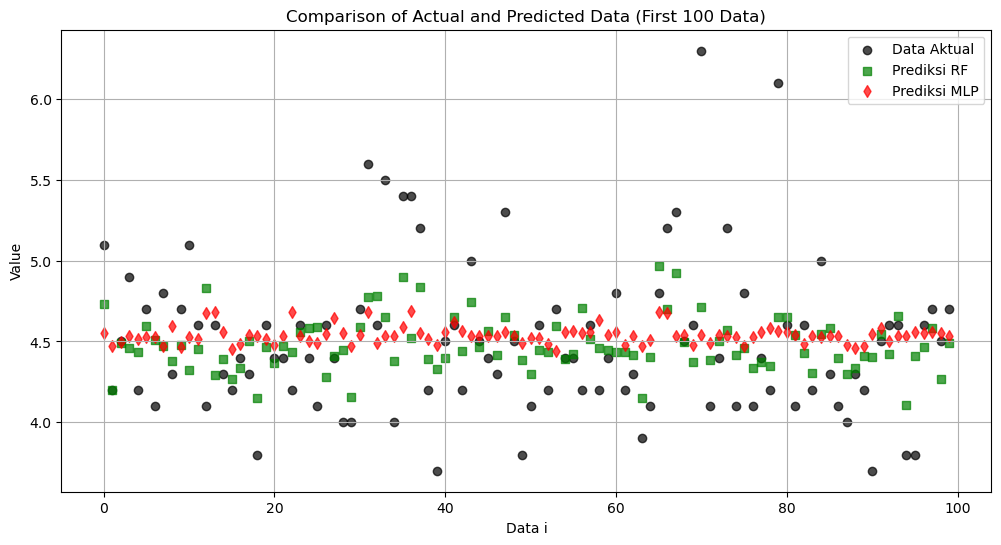

In [43]:
prediction_result = pd.DataFrame({
    'True Labels': y,
    'RF Prediction': rf_prediction,
    # 'XGB Prediction': xgb_prediction,
    'MLP Prediction': mlp_prediction_flat
})

# Get the first 100 data points (adjust as needed)
data_subset = prediction_result.sample(100)

# Create the plot
plt.figure(figsize=(12, 6))

# Scatter plot for actual data (black)
plt.scatter(x=range(len(data_subset['True Labels'])), 
            y=data_subset['True Labels'], 
            color='black', 
            marker='o', 
            alpha=0.7, 
            label='Data Aktual')

# Scatter plot for RF prediction (green)
plt.scatter(x=range(len(data_subset['RF Prediction'])), 
            y=data_subset['RF Prediction'], 
            color='green', 
            marker='s', 
            alpha=0.7, 
            label='Prediksi RF')

# # Scatter plot for XGB prediction (blue)
# plt.scatter(x=range(len(data_subset['XGB Prediction'])), 
#             y=data_subset['XGB Prediction'], 
#             color='blue', 
#             marker='^', 
#             alpha=0.7, 
#             label='Prediksi XGB')

# Scatter plot for MLP prediction (red)
plt.scatter(x=range(len(data_subset['MLP Prediction'])), 
            y=data_subset['MLP Prediction'], 
            color='red', 
            marker='d', 
            alpha=0.7, 
            label='Prediksi MLP')

# Add labels and title
plt.title('Comparison of Actual and Predicted Data (First 100 Data)')
plt.xlabel('Data i')
plt.ylabel('Value')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Display the plot
plt.show()